<a href="https://colab.research.google.com/github/lyanausa/MachineLearningforEnergySystemsApplications/blob/main/EE4720_Project_Lyana_Usa_and_Marcel_Brouwers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE4720 Machine Learning for  Energy Systems Applications: Project IEEE 9 Bus Test Systems
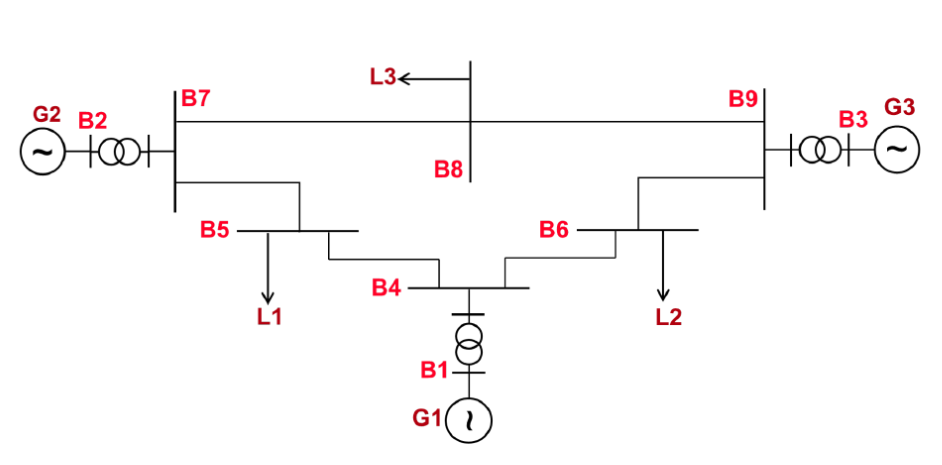

The given data of this project is referred as INITIAL DATASET and contains datapoints with the feature matrix F, that is constructed as follows:
             𝐹 =(𝑃𝑖,𝑄𝑖,𝑉𝑖,𝜃𝑖,𝑃𝑖𝑗,𝑄𝑖𝑗) for 𝑖 = 1,...,9
            
The feature matrix contains 216 features in total. Note that if the line 𝑖𝑗 does not exits, then  𝑃𝑖𝑗 = 𝑄𝑖𝑗 =0.
- Task 1: Data Pre-Processing
- Task 2: Risk Factor Estimation
- Task 3: Risk State Estimation

By Marcel Brouwers and Lyana Usa
2021

In [ ]:
# Import the Input data from github
import sys
import os

!git clone https://github.com/lyanausa/MachineLearningforEnergySystemsApplications.git

fatal: destination path 'MachineLearningforEnergySystemsApplications' already exists and is not an empty directory.


In [ ]:
# Data input
import pandas as pd
data = pd.read_csv('MachineLearningforEnergySystemsApplications/Project_InputData.csv') 
data


,Unnamed: 0,Bus Voltage-1,Bus Voltage-2,Bus Voltage-3,Bus Voltage-4,Bus Voltage-5,Bus Voltage-6,Bus Voltage-7,Bus Voltage-8,Bus Voltage-9,Bus Angles-1,Bus Angles-2,Bus Angles-3,Bus Angles-4,Bus Angles-5,Bus Angles-6,Bus Angles-7,Bus Angles-8,Bus Angles-9,P generation-1,P generation-2,P generation-3,P generation-4,P generation-5,P generation-6,P generation-7,P generation-8,P generation-9,Q generation-1,Q generation-2,Q generation-3,Q generation-4,Q generation-5,Q generation-6,Q generation-7,Q generation-8,Q generation-9,P demand-1,P demand-2,P demand-3,...,Qflow Bus 5-7,Qflow Bus 5-8,Qflow Bus 5-9,Qflow Bus 6-1,Qflow Bus 6-2,Qflow Bus 6-3,Qflow Bus 6-4,Qflow Bus 6-5,Qflow Bus 6-6,Qflow Bus 6-7,Qflow Bus 6-8,Qflow Bus 6-9,Qflow Bus 7-1,Qflow Bus 7-2,Qflow Bus 7-3,Qflow Bus 7-4,Qflow Bus 7-5,Qflow Bus 7-6,Qflow Bus 7-7,Qflow Bus 7-8,Qflow Bus 7-9,Qflow Bus 8-1,Qflow Bus 8-2,Qflow Bus 8-3,Qflow Bus 8-4,Qflow Bus 8-5,Qflow Bus 8-6,Qflow Bus 8-7,Qflow Bus 8-8,Qflow Bus 8-9,Qflow Bus 9-1,Qflow Bus 9-2,Qflow Bus 9-3,Qflow Bus 9-4,Qflow Bus 9-5,Qflow Bus 9-6,Qflow Bus 9-7,Qflow Bus 9-8,Qflow Bus 9-9,Risk Factor
0,0,1.04,1.025,1.025,1.051752,1.052997,1.045422,1.045174,1.044088,1.044771,0.0,-0.557943,-1.733543,147.899451,146.653695,145.896902,147.904255,146.663846,147.365029,69.000000,46.000000,28.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,17.817656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-24.300566,0.0,0.0,0.0,0.0,0.0,-8.497492,0.0,0.0,0.0,0.0,-23.305716,0.0,-32.467650,0.0,0.0,-9.031824,0.0,0.0,-5.504336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.052955,0.0,-12.169921,0.0,0.0,-34.356254,0.0,0.0,-15.395107,0.0,-10.467886,0.0,0.000000
1,1,1.04,1.025,1.025,1.045137,1.021813,1.036321,1.036890,1.035527,1.038926,0.0,-10.001383,-7.946156,147.407459,134.502249,143.226010,138.448522,138.447102,141.147342,83.137497,46.000000,28.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.508236,17.817656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-14.268545,0.0,0.0,0.0,0.0,0.0,-11.253288,0.0,0.0,0.0,0.0,-12.406321,0.0,-18.876555,0.0,0.0,-15.021286,0.0,0.0,-9.917054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.078751,0.0,-12.510075,0.0,0.0,-24.130608,0.0,0.0,-25.342725,0.0,-7.625909,0.0,0.000000
2,2,1.04,1.025,1.025,1.048968,1.048291,1.038432,1.042474,1.039527,1.042019,0.0,-2.511640,-3.705126,147.029321,145.181476,144.303489,145.946575,144.501550,145.391065,97.275002,46.000000,28.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.508236,17.817656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-21.930634,0.0,0.0,0.0,0.0,0.0,-5.841562,0.0,0.0,0.0,0.0,-19.870847,0.0,-28.038566,0.0,0.0,-11.377447,0.0,0.0,-7.356258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.834381,0.0,-10.619643,0.0,0.0,-29.542666,0.0,0.0,-18.642362,0.0,-11.757630,0.0,0.000000
3,3,1.04,1.025,1.025,1.044267,1.038909,0.963355,1.030858,1.022136,1.023767,0.0,-12.802038,-20.324320,146.429669,141.141825,121.735481,135.638799,131.432356,128.755757,111.412498,46.000000,28.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.508236,17.817656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.075913,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.479749,0.0,-8.980876,0.0,0.0,-20.761829,0.0,0.0,-3.608291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.211719,0.0,-2.557104,0.0,0.0,2.386848,0.0,0.0,-29.549593,0.0,-17.076432,0.0,0.000000
4,4,1.04,1.025,1.025,1.045679,1.043050,1.030835,1.039573,1.034735,1.039076,0.0,-4.504490,-5.718441,146.147145,143.683155,142.678792,143.949421,142.295425,143.375190,125.550003,46.000000,28.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.508236,17.817656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-19.290726,0.0,0.0,0.0,0.0,0.0,-2.913570,0.0,0.0,0.0,0.0,-16.165348,0.0,-23.278624,0.0,0.0,-13.872658,0.0,0.0,-9.198725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.569036,0.0,-9.022071,0.0,0.0,-24.394474,0.0,0.0,-22.055516,0.0,-13.056821,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif , f_classif, f_regression

import copy
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPRegressor

# Pre-Processing: 
Data preparation is required for the missing data.


**Part 1: Remove zero-entry columns/features: Delete the columns from the dataset that contains only zeros:**


In [ ]:
data_reshaped = data.loc[: ,(data != 0).any(axis = 0)] # It deletes the columns that contain only zeros 
#data_reshaped = data.loc[:, (data == 0).all(axis=0)] # Columns with only zero entry
print(data_reshaped.shape)
print(data_reshaped) 

print(data.columns.get_loc('Qflow Bus 9-9'))
print(data.iloc[677, 216])

#value_Qbus_nnzero = np.nonzero(data['Qflow Bus 9-9'])
#print('Non zero values in Column Qflow Bus 9-9 : ', value_Qbus_nnzero )

print(data_reshaped['Risk Factor'].value_counts()) # check the frequency of risk factor values



(4955, 207)
      Unnamed: 0  Bus Voltage-1  ...  Qflow Bus 9-9  Risk Factor
0              0           1.04  ...            0.0     0.000000
1              1           1.04  ...            0.0     0.000000
2              2           1.04  ...            0.0     0.000000
3              3           1.04  ...            0.0     0.000000
4              4           1.04  ...            0.0     0.000000
...          ...            ...  ...            ...          ...
4950        4950           1.04  ...            0.0     1.000000
4951        4951           1.04  ...            0.0     0.600000
4952        4952           1.04  ...            0.0     0.333333
4953        4953           1.04  ...            0.0     0.333333
4954        4954           1.04  ...            0.0     0.466667

[4955 rows x 207 columns]
216
nan
0.000000    1146
0.133333     761
0.333333     653
0.666667     384
0.866667     236
0.600000     228
0.733333     205
1.000000     199
0.400000     192
0.266667     182
0.8

**Part 1: Make the features matrix and the output matrix y:**

In [ ]:
data_features = data_reshaped.iloc[:,1:len(data_reshaped.iloc[0,:])-1]
print(data_features.shape)
print(data_features)


y = data_reshaped.iloc[:,len(data_reshaped.iloc[0,:])-1]  # Risk factor is the y matrix
print(y.shape)
print(y)

(4955, 205)
      Bus Voltage-1  Bus Voltage-2  ...  Qflow Bus 9-8  Qflow Bus 9-9
0              1.04          1.025  ...     -10.467886            0.0
1              1.04          1.025  ...      -7.625909            0.0
2              1.04          1.025  ...     -11.757630            0.0
3              1.04          1.025  ...     -17.076432            0.0
4              1.04          1.025  ...     -13.056821            0.0
...             ...            ...  ...            ...            ...
4950           1.04          1.025  ...       0.000000            0.0
4951           1.04          1.025  ...     -29.016037            0.0
4952           1.04          1.025  ...     -20.966076            0.0
4953           1.04          1.025  ...     -30.882850            0.0
4954           1.04          1.025  ...     -38.204832            0.0

[4955 rows x 205 columns]
(4955,)
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
4950    1.0

**Task 1, dataset 1**

In [ ]:
# Detect the missing values and impute those with the mean of the corresponding column

names = data_features.columns; # Get names of the features
print(names)
print("The total of columns names are: ", names.shape)
print("The total amount of missing values are: " , data_features.isna().sum().sum())
idx = np.where(np.isnan(data_features))


missing_features_names = names[idx[1]]
#print(missing_features_names)
for i in range(len(missing_features_names)):
  a = idx[0][i] # gives the row of the NaN
  #print(a)
  b = idx[1][i] # gives the column of the NaN 
  #print(b)
  data_features.iloc[a,b] = data_features.iloc[:,b].mean() # locates the coordinates in the matrix of the NaN and imputes the NaN with the mean of the column 
  #print(data)

data_features_new = data_features.loc[: ,(data_features != 0).any(axis = 0)] # Firstly, It deletes the columns that contain only zeros
print('The imputed data set with all-zero columns deleted looks as follows: ', data_features_new)
print('The shape of that matrix is : ',data_features_new.shape)

imputed_data = np.copy(data_features_new) # Make an array that is a copy of the imputed data without all-zero columns
#imputed_data = np.copy(data_features) # Make an array that is a copy of the imputed data
print(imputed_data)
print(imputed_data.shape)

# Check if there are any NaN in the imputed dataset
NaN_check = np.isnan(imputed_data).sum().sum()
print("The total amount of NaN after imputing with the mean is: ", NaN_check) # This should be zero after the original dataset was imputed


Index(['Bus Voltage-1', 'Bus Voltage-2', 'Bus Voltage-3', 'Bus Voltage-4',
       'Bus Voltage-5', 'Bus Voltage-6', 'Bus Voltage-7', 'Bus Voltage-8',
       'Bus Voltage-9', 'Bus Angles-1',
       ...
       'Qflow Bus 8-9', 'Qflow Bus 9-1', 'Qflow Bus 9-2', 'Qflow Bus 9-3',
       'Qflow Bus 9-4', 'Qflow Bus 9-5', 'Qflow Bus 9-6', 'Qflow Bus 9-7',
       'Qflow Bus 9-8', 'Qflow Bus 9-9'],
      dtype='object', length=205)
The total of columns names are:  (205,)
The total amount of missing values are:  496
The imputed data set with all-zero columns deleted looks as follows:        Bus Voltage-1  Bus Voltage-2  ...  Qflow Bus 9-6  Qflow Bus 9-8
0              1.04          1.025  ...     -15.395107     -10.467886
1              1.04          1.025  ...     -25.342725      -7.625909
2              1.04          1.025  ...     -18.642362     -11.757630
3              1.04          1.025  ...     -29.549593     -17.076432
4              1.04          1.025  ...     -22.055516     -13.05682

**Task 1, dataset 2**

In [ ]:
# Detect the missing values and delete the rows containing said values.
data2 = pd.read_csv('MachineLearningforEnergySystemsApplications/Project_InputData.csv') # Ik heb even opnieuw de data voor je geload. Merci
names2 = data2.columns

# Transform the data from a panda (nice to look at) to an array (handy to work with for me)
data_array = np.zeros([data2.shape[0],data2.shape[1]])

for k in range(data2.shape[1]):
    data_array[:,k] = np.array(data2.loc[0:data2.shape[0] , [names2[k]]]).reshape(data2.shape[0])
    
data = data_array

# determine which samples have missing data:
miss_sample = []
lookfor_NAN = []

for k in range(data.shape[0]):
    lookfor_NAN.append(np.isnan(data[k,:]))
        
for k in range(data.shape[0]):
    if np.any(lookfor_NAN[k]) == True:
        #print("row with NAN value entries:", k)
        miss_sample.append(k)
        
miss_sample = np.array(miss_sample)

miss_ind = np.sort(miss_sample)[::-1] # swap the entries for easier deletion
data_new = copy.copy(data) # copy the data such that we can use it later if necessary

# Delete the samples with data missing and use the remaining data.
for i in range(miss_ind.shape[0]):
    data_new = np.delete(data_new,miss_ind[i],axis=0)

In [ ]:
print(data_new.shape)
print(data_new)
print(names2.shape)

(4459, 218)
[[ 1.00000000e+00  1.03999996e+00  1.02500002e+00 ... -7.62590929e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00  1.03999996e+00  1.02499998e+00 ... -1.17576303e+01
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00  1.03999996e+00  1.02499998e+00 ... -1.70764318e+01
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.95200000e+03  1.03999996e+00  1.02500003e+00 ... -2.09660759e+01
   0.00000000e+00  3.33333333e-01]
 [ 4.95300000e+03  1.03999996e+00  1.02499998e+00 ... -3.08828496e+01
   0.00000000e+00  3.33333333e-01]
 [ 4.95400000e+03  1.03999996e+00  1.02499998e+00 ... -3.82048321e+01
   0.00000000e+00  4.66666667e-01]]
(218,)


In [ ]:
# Remove 0 entry columns
zero_col = []

for i in range(data_new.shape[1]):
    if np.count_nonzero(data_new[:,i]) == 0:
        zero_col.append(i)

zero_col = np.array(zero_col)
print('Number of columns with only 0 as entries:', zero_col.shape[0])

zero_col = np.sort(zero_col)[::-1] # swap the entries for easier deletion
data_free = copy.copy(data_new) # copy the data such that we can use it later if necessary
names_free = copy.copy(names2)

# Delete the features with only zeros as entries.
for i in range(zero_col.shape[0]):
    data_free = np.delete(data_free,zero_col[i],axis=1)
    names_free = np.delete(names_free,zero_col[i],axis=0)

print(data_free.shape)
print(data_free)

Number of columns with only 0 as entries: 152
(4459, 66)
[[ 1.00000000e+00  1.03999996e+00  1.02500002e+00 ... -2.53427250e+01
  -7.62590929e+00  0.00000000e+00]
 [ 2.00000000e+00  1.03999996e+00  1.02499998e+00 ... -1.86423619e+01
  -1.17576303e+01  0.00000000e+00]
 [ 3.00000000e+00  1.03999996e+00  1.02499998e+00 ... -2.95495931e+01
  -1.70764318e+01  0.00000000e+00]
 ...
 [ 4.95200000e+03  1.03999996e+00  1.02500003e+00 ... -4.24847836e+01
  -2.09660759e+01  3.33333333e-01]
 [ 4.95300000e+03  1.03999996e+00  1.02499998e+00 ... -3.03547495e+01
  -3.08828496e+01  3.33333333e-01]
 [ 4.95400000e+03  1.03999996e+00  1.02499998e+00 ... -5.63044436e+01
  -3.82048321e+01  4.66666667e-01]]


In [ ]:
# "quick" visual check, uncomment if you want to use it
#np.set_printoptions(threshold=10000) # up the threshold such that we can see the full column
#for k in range(zero_col.shape[0]):
#    print(data_new[:,zero_col[k]])
#np.set_printoptions(threshold = False) # reset the settings again

In [ ]:
# for dataset 2:
y_2 = data_free[:,data_free.shape[1]-1]
y_names = names_free[names_free.shape[0]-1]
X_2 = np.delete(data_free, data_free.shape[1]-1, 1)
X_2 = np.delete(X_2, 0, 1)
X_names = np.delete(names_free, names_free.shape[0]-1)
X_names = np.delete(X_names, 0)
X_index = data_free[:,0]
X_index_names = names_free[0]

print(X_names.shape)
print(X_2.shape)
print(X_index)
print(y_names)
print(y_2.shape)

(64,)
(4459, 64)
[1.000e+00 2.000e+00 3.000e+00 ... 4.952e+03 4.953e+03 4.954e+03]
Risk Factor
(4459,)


End of dataset 2 preperation

In [ ]:
# normalization:

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer

# 'normalize' provides a quick and easy way to perform this operation on a single array-like dataset, 
# either using the l1 (sum of the absolute value), l2 (sqrt of the sum of the squares), or max (max absolute element) norms

# class sklearn.preprocessing.Normalizer(norm='l2', *, copy=True)
# norm can be l1, l2, max

# Normalize samples individually to unit norm:
# Each sample (i.e. each row of the data matrix) with at least one non zero component 
# is rescaled independently of other samples so that its norm (l1, l2 or inf) equals one.

# the fit method does nothing but is useful when used in a pipeline.

# normalize --> rescale to the interval between 0 and 1 --> not taking the norm

**Pipeline Pre-processing**

The datasets have now been cleaned, but there is still a bit more to do before the pre-processing is done. Most ML models require the samples to be within a certain similair range. To this end, we perform stadrdization.

Now standardization can be done in several ways. The two main ways treated during this course include standardization and normalization.

Thus before we continue with the regression and classification models, we'll test two pipelines with a simple model to test both normalization and standardization.

In [ ]:
#######################################################################################################################
# Pre-processing: use to print results of the gridsearch.
#######################################################################################################################

def PrintMySearch_Reg(Mysearch):
    print("Best Param: ", Mysearch.best_params_)
    print("Best Estimator", Mysearch.best_estimator_)
    Sresults=Mysearch.cv_results_
    
    plt.figure(figsize=(8,4))
    #plt.plot(Sresults['mean_test_score'])      # mean_test_score only works if you only have 1 score type
    plt.plot(Sresults['mean_test_MSE'])
    plt.ylabel("score")
    plt.title('GridSearchCV Score results')
    plt.grid(axis = 'y',linestyle='--')
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(Sresults['mean_test_r2'])
    plt.ylabel("score")
    plt.title('GridSearchCV Score results')
    plt.grid(axis = 'y',linestyle='--')
    plt.show()
    
    for mean_score, params in zip(Sresults['mean_test_MSE'],Sresults['params']):
        print('-MSE score:', ' %.6f'%mean_score,params)
        
    for mean_score, params in zip(Sresults['mean_test_r2'],Sresults['params']):
        print('R2 score:', ' %.6f'%mean_score,params)

In [ ]:
# We get the occasional FP error with regards to devision.
# To make sure that hese don't keep popping up we'll turn them off for now.

# Set how floating-point errors are handled.
# Note that operations on integer scalar types (such as int16) are handled like floating point, and are affected by these settings.
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Best Param:  {'selectK__k': 40}
Best Estimator Pipeline(steps=[('normalize', MinMaxScaler()),
                ('selectK',
                 SelectKBest(k=40,
                             score_func=<function f_regression at 0x7f98de356a70>)),
                ('SVR', SVR(C=2, gamma=0.05))])


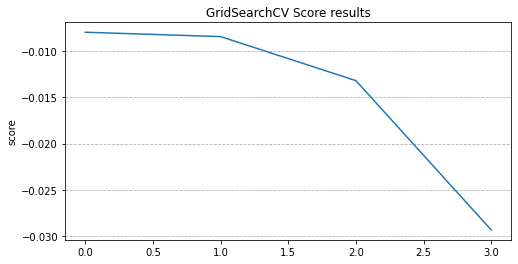

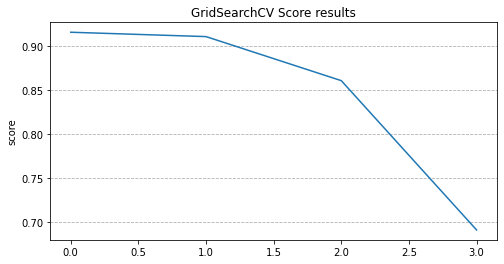

-MSE score:  -0.007988 {'selectK__k': 40}
-MSE score:  -0.008459 {'selectK__k': 30}
-MSE score:  -0.013211 {'selectK__k': 20}
-MSE score:  -0.029327 {'selectK__k': 10}
R2 score:  0.915951 {'selectK__k': 40}
R2 score:  0.911001 {'selectK__k': 30}
R2 score:  0.860970 {'selectK__k': 20}
R2 score:  0.691446 {'selectK__k': 10}
MSE score is: 0.00832
R2 score is: 0.92126


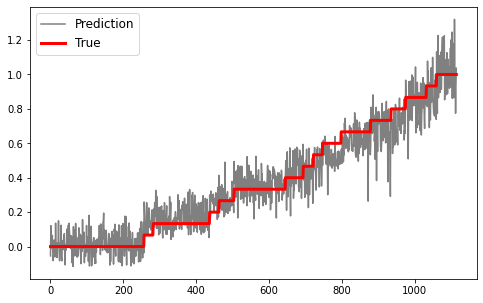

In [ ]:
#######################################################################################################################
# Pre-processing Pipeline 1: normalization
#######################################################################################################################
# ratio with which the data will be split
Test_ratio = 0.25
# split data in test and training data
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

# define the scoring metrics which we're going to use
scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('normalize', MinMaxScaler(feature_range=(0, 1))),             # normalize the data [0,1]
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('SVR', SVR(C=2,kernel='rbf',gamma=0.05))                      # SVM regressor
])

HP_space = {                        # define the different hyper-parameters which we want to vary
    'selectK__k':[40,30,20,10]
}

# Perform gridsearch
search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
# cv = cross-validation folds --> we don't need a validation dataset
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

# determine the MSE score
print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
# determine the R2 score
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

# print the results
sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f98de356a70>)),
                ('SVR', SVR(C=2, gamma=0.05))])


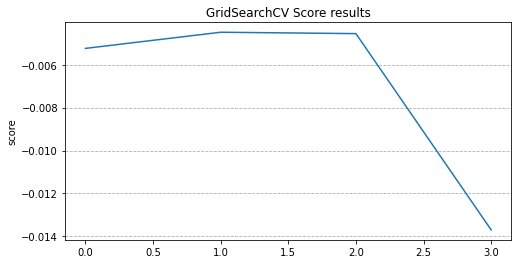

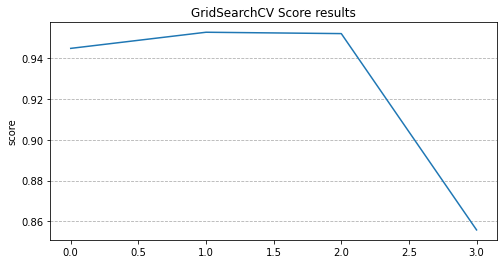

-MSE score:  -0.005238 {'selectK__k': 40}
-MSE score:  -0.004485 {'selectK__k': 30}
-MSE score:  -0.004549 {'selectK__k': 20}
-MSE score:  -0.013702 {'selectK__k': 10}
R2 score:  0.944870 {'selectK__k': 40}
R2 score:  0.952782 {'selectK__k': 30}
R2 score:  0.952115 {'selectK__k': 20}
R2 score:  0.855809 {'selectK__k': 10}
MSE score is: 0.00456
R2 score is: 0.95682


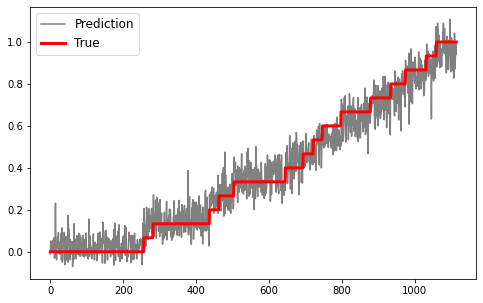

In [ ]:
#######################################################################################################################
# Pre-processing Pipeline 2: standardization
#######################################################################################################################
# ratio with which the data will be split
Test_ratio = 0.25
# split data in test and training data
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

# define the scoring metrics which we're going to use
scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('SVR', SVR(C=2,kernel='rbf',gamma=0.05))                      # SVM regressor
])

HP_space = {                        # define the different hyper-parameters which we want to vary
    'selectK__k':[40,30,20,10]
}

# Perform gridsearch
search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
# cv = cross-validation folds --> we don't need a validation dataset
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

# determine the MSE score
print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
# determine the R2 score
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

# print the results
sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Regualr standardization seems to win out.
Both the R2 score is higher and the MSE is almost halved.

# Classification: Risk State 

**Classification of the Risk State: Risk State Pipeline 1**
The output is the prediction of the risk state, that is a discrete outcome chosen out of the four possible state:

*   Safe: R < 0.1 
*   Low Risk: 0.1≤𝑅<0.35 
*   Moderate Risk: 0.35≤𝑅 <0.7
*   High Risk: 0.7<𝑅




# **Dataset 1**

[0.         0.         0.         ... 0.33333333 0.33333333 0.46666667]
[0 0 0 ... 1 1 2]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 2. 0. 0.]
[[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]]


Text(0.5, 1.0, 'Histogram of the Risk State')

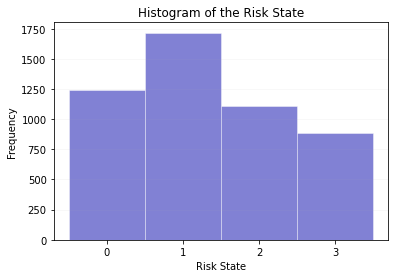

In [ ]:
#---- Relabel the y matrix to define the four classes for Dataset 1 ---- #
#print(y[0:300])
y_risk =  np.copy(y)
print(y_risk)

for i in range(len(y_risk)):
  if y_risk[i] < 0.1:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk[i]= 0; # Safe = 0
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  elif y_risk[i] > 0.7:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk[i]= 3; # High Risk = 3
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  elif y_risk[i] < 0.7 and y_risk[i] >= 0.35:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk[i]=2; # Moderate Risk = 2
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  else:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk[i]=1; # Low Risk = 1
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])

print(y_risk.astype(int)) # Ensure the labels are integers
print(y_risk[40:60])
from sklearn.preprocessing import LabelBinarizer
y_dense = LabelBinarizer().fit_transform(y_risk)
print(y_dense[40:60])

# Plot histogram of y risk states
n, bins, patches = plt.hist(x=y_risk, bins= np.arange(5)-0.5,  color='#0504aa', alpha=0.5,linewidth=0.8, edgecolor='white'
#n, bins, patches = plt.hist(x=y_risk, bins= 'auto',  color='#0504aa', alpha=0.5,linewidth=0.8, edgecolor='white'
                            )
plt.grid(axis='y',alpha=0.1)

plt.xlabel('Risk State')
plt.ylabel('Frequency')
plt.xticks(range(4))
#plt.xticks(np.linspace(0,3,1))
#plt.axis(['Safe', 'Low Risk', 'Moderate Risk', 'High Risk'])
plt.title('Histogram of the Risk State')
#plt.text(23, 45, r'$\mu=15, b=3$')

**# Code for printing the GridSearch parameters**

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
def PrintMySearch_Clf(Mysearch):
    print("Best Param: ", Mysearch.best_params_)
    print("Best Estimator", Mysearch.best_estimator_)
    Sresults=Mysearch.cv_results_
    
    plt.figure(figsize=(8,4))
    plt.plot(Sresults['mean_test_accuracy'])
    plt.ylabel("score")
    plt.title('GridSearchCV Score results')
    plt.grid(axis = 'y',linestyle='--')
    plt.show()
    
    for mean_score, params in zip(Sresults['mean_test_accuracy'],Sresults['params']):
        print(' Accuracy is %.6f'%mean_score,params)

    for mean_score, params in zip(Sresults['mean_test_precision'],Sresults['params']):
        print(' Precision %.6f'%mean_score,params)

    for mean_score, params in zip(Sresults['mean_test_recall'],Sresults['params']):
        print('Recall %.6f'%mean_score,params)

    for mean_score, params in zip(Sresults['mean_test_f1'],Sresults['params']):
        print('f1 %.6f'%mean_score,params)
        
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}



In [ ]:
 Confusion matrix and performance metrics 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

**kNN model**

In [ ]:

X_train_imputed_1, X_test_imputed_1, y_train_imputed_1, y_test_imputed_1 = train_test_split(imputed_data, y_risk, test_size=0.25, random_state=4720)

print('The shape of the train set of the imputed data set is: ', X_train_imputed_1.shape)
print('The shape of the test set of the imputed data set is: ', X_test_imputed_1.shape)
print('The shape of the y train: ', y_train_imputed_1.shape)
print('The shape of the y test: ', y_test_imputed_1.shape)
print(y_test_imputed_1)

from sklearn import neighbors

RS_pipeline_1 = Pipeline([
                 ('standardize', StandardScaler()),
                 ('selectK', SelectKBest(score_func=f_classif, k=20)),
                 ('classifier', neighbors.KNeighborsClassifier())
])

HP_space_RS_1={
               #'selectK__score_func':[f_classif,mutual_info_classif], # f_classif is better than 
               'selectK__k':[30,20,10],

         }

search_RS_1 = GridSearchCV(RS_pipeline_1, HP_space_RS_1, cv=5, scoring=scoring, refit='accuracy') 


## =======================View the scaled data ========================== 
#from sklearn.compose import ColumnTransformer
#numeric_features = data_features_new.select_dtypes(include=['int64', 'float64']).columns

#encoded_check = ColumnTransformer(
#    transformers=[
#         ('cat', categorical_transformer, categorical_features)
#    ])encoded_columns = encoded_check.fit_transform(dataset)
#encoded_columns[0:5]

#scaled_check_RS_1 = ColumnTransformer(
#    transformers=[
#         ('num ', RS_pipeline_1 ,numeric_features)
#    ])
#scaled_columns_RS_1 = encoded_check.fit_transform(imputed_data)
#scaled_columns_RS_1[0:5]
## ============================== Training ==============================
search_RS_1.fit(X_train_imputed_1,y_train_imputed_1)


PrintMySearch_Clf(search_RS_1)

## ============================== Testing ===============================

bestmodel_RS_1=search_RS_1.best_estimator_

y_predict_RS_1=bestmodel_RS_1.predict(X_test_imputed_1)


# ------------- performance parameters ------------------- #
print('Accuracy score is: %.5f'%accuracy_score(y_test_imputed_1,y_predict_RS_1))


sort_ind_RS_1=np.argsort(y_test_imputed_1)
plt.figure(figsize=(8,5))
plt.plot(y_predict_RS_1[sort_ind_RS_1],linewidth=1.5,c='gray')
plt.plot(y_test_imputed_1[sort_ind_RS_1],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

# Confusion matrix 
from sklearn.metrics import plot_confusion_matrix
confusion_matrix_RS_1 = plot_confusion_matrix(search_RS_1, X_test_imputed_1, y_test_imputed_1,display_labels=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"])
confusion_matrix_RS_1.figure_.suptitle("Confusion Matrix for Risk State Classification Model 1")
plt.show()

The shape of the train set of the imputed data set is:  (3716, 64)
The shape of the test set of the imputed data set is:  (1239, 64)
The shape of the y train:  (3716,)
The shape of the y test:  (1239,)
[1. 1. 1. ... 3. 2. 0.]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constan

KeyboardInterrupt: ignored

**SVM Model**

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/li

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('scale', StandardScaler()), ('selectK', SelectKBest(k=30)),
                ('SVC', SVC(C=3, gamma=0.05))])


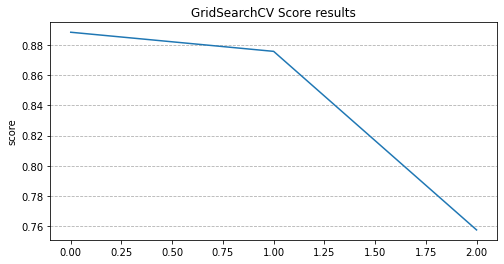

 Accuracy is 0.888320 {'selectK__k': 30}
 Accuracy is 0.875672 {'selectK__k': 20}
 Accuracy is 0.757548 {'selectK__k': 10}
 Precision 0.892046 {'selectK__k': 30}
 Precision 0.881010 {'selectK__k': 20}
 Precision 0.761978 {'selectK__k': 10}
Recall 0.884441 {'selectK__k': 30}
Recall 0.870213 {'selectK__k': 20}
Recall 0.738965 {'selectK__k': 10}
f1 0.887607 {'selectK__k': 30}
f1 0.874644 {'selectK__k': 20}
f1 0.746013 {'selectK__k': 10}
Accuracy score is: 0.88701


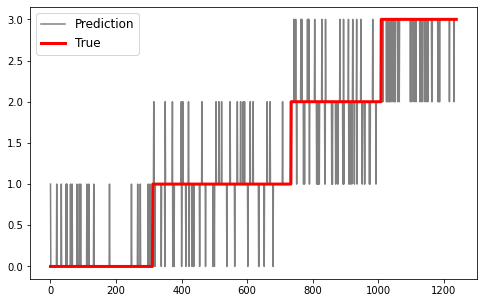

In [ ]:
pipe=Pipeline([ 
    ('scale',StandardScaler())
    ,('selectK', SelectKBest(score_func=f_classif, k=20))          #select k best features
    ,('SVC', SVC(C=3,kernel='rbf',gamma=0.05))          #SVM classifier
])

HP_space={
         #'selectK__score_func':[f_classif,mutual_info_classif],
         'selectK__k':[30,20,10],
         #'SVC__C':[0.1,2],
         #'SVC__kernel':['poly','rbf'],
         #'SVC__gamma':[0.01,0.05]
         }

search = GridSearchCV(pipe, HP_space, cv=5,scoring=scoring, refit='accuracy')


## ============================== Training ===============================
search.fit(X_train_imputed_1,y_train_imputed_1)


PrintMySearch_Clf(search)

## ============================== Testing ===============================

bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test_imputed_1)



print('Accuracy score is: %.5f'%accuracy_score(y_test_imputed_1,y_predict))

sort_ind=np.argsort(y_test_imputed_1)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test_imputed_1[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

**Logistic regression model**

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/li

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK', SelectKBest(k=30)),
                ('logistic',
                 LogisticRegression(max_iter=1000, random_state=4720))])


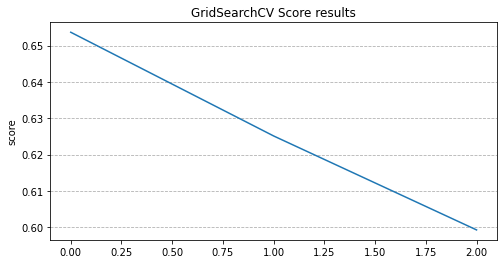

 Accuracy is 0.653655 {'selectK__k': 30}
 Accuracy is 0.625130 {'selectK__k': 20}
 Accuracy is 0.599293 {'selectK__k': 10}
 Precision 0.659162 {'selectK__k': 30}
 Precision 0.625998 {'selectK__k': 20}
 Precision 0.595761 {'selectK__k': 10}
Recall 0.650596 {'selectK__k': 30}
Recall 0.614114 {'selectK__k': 20}
Recall 0.584434 {'selectK__k': 10}
f1 0.652280 {'selectK__k': 30}
f1 0.613948 {'selectK__k': 20}
f1 0.582944 {'selectK__k': 10}


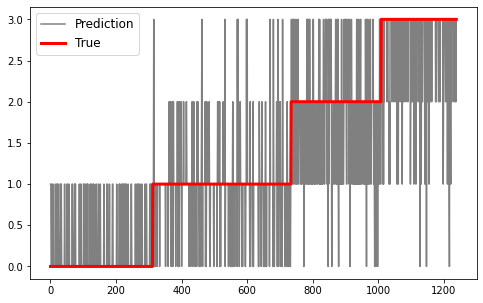

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000, random_state=4720)
pipe_logistic_RS_1 = Pipeline([
                 ('standardize', StandardScaler()),
                 ('selectK', SelectKBest(score_func=f_classif, k=20)),
                  ('logistic', logistic)
                ])
HP_space_RS_1_Logistic={
               #'selectK__score_func':[f_classif,mutual_info_classif], # f_classif is better than 
               'selectK__k':[30,20,10],
               #'logistic__C': [5,1,50],
         }

#scoring = {'precision_score': make_scorer(precision_score), "Accuracy": make_scorer(accuracy_score)}
search_RS_1_logistic = GridSearchCV(pipe_logistic_RS_1, HP_space_RS_1_Logistic, cv=5, scoring=scoring, refit='accuracy') 
search_RS_1_logistic.fit(X_train_imputed_1,y_train_imputed_1)

PrintMySearch_Clf(search_RS_1_logistic)

## ============================== Testing ===============================

bestmodel_RS_log=search_RS_1_logistic.best_estimator_

y_predict_RS_1_log=bestmodel_RS_log.predict(X_test_imputed_1)


# ------------- performance parameters ------------------- #

sort_ind_RS_1_log=np.argsort(y_test_imputed_1)
plt.figure(figsize=(8,5))
plt.plot(y_predict_RS_1_log[sort_ind_RS_1_log],linewidth=1.5,c='gray')
plt.plot(y_test_imputed_1[sort_ind_RS_1_log],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

**Random Forest**

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/li

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('scale', StandardScaler()), ('selectK', SelectKBest(k=30)),
                ('classifier', RandomForestClassifier(random_state=4720))])


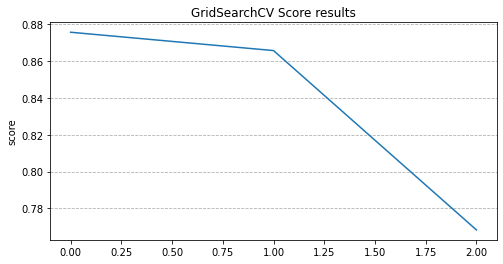

 Accuracy is 0.875669 {'selectK__k': 30}
 Accuracy is 0.865714 {'selectK__k': 20}
 Accuracy is 0.768309 {'selectK__k': 10}
 Precision 0.882082 {'selectK__k': 30}
 Precision 0.870243 {'selectK__k': 20}
 Precision 0.766971 {'selectK__k': 10}
Recall 0.868125 {'selectK__k': 30}
Recall 0.857380 {'selectK__k': 20}
Recall 0.753804 {'selectK__k': 10}
f1 0.874039 {'selectK__k': 30}
f1 0.862850 {'selectK__k': 20}
f1 0.758742 {'selectK__k': 10}
Accuracy score is: 0.89023


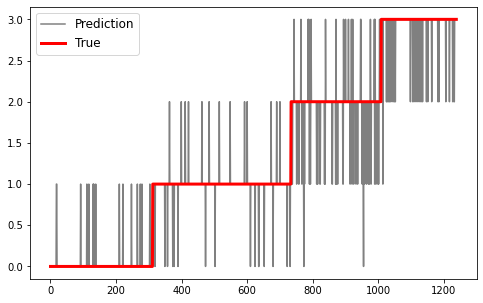

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
pipe=Pipeline([ 
    ('scale',StandardScaler())
    ,('selectK', SelectKBest(score_func=f_classif, k=20))          #select k best features
    ,('classifier', RandomForestClassifier(random_state = 4720))
    #,('classifier', GradientBoostingClassifier(random_state = 42))
])

HP_space={
         #'selectK__score_func':[f_classif,mutual_info_classif],
         'selectK__k':[30,20,10],

         }

search = GridSearchCV(pipe, HP_space, cv=5,scoring=scoring, refit='accuracy')

## ============================== Training ===============================
search.fit(X_train_imputed_1,y_train_imputed_1)


PrintMySearch_Clf(search)

## ============================== Testing ===============================

bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test_imputed_1)



print('Accuracy score is: %.5f'%accuracy_score(y_test_imputed_1,y_predict))

sort_ind=np.argsort(y_test_imputed_1)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test_imputed_1[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

**Chosen model for classification of Dataset 1: Model 1 SVM**

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/li

Best Param:  {'SVC__C': 2, 'SVC__gamma': 'scale', 'SVC__kernel': 'rbf', 'selectK__k': 25, 'selectK__score_func': <function f_classif at 0x7f6af556c440>}
Best Estimator Pipeline(steps=[('scale', StandardScaler()), ('selectK', SelectKBest(k=25)),
                ('SVC', SVC(C=2))])


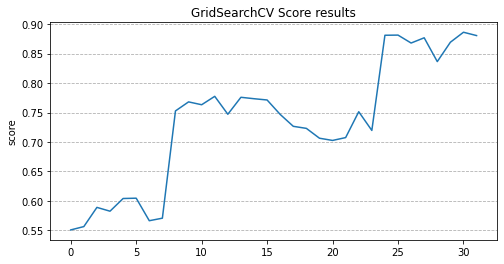

 Accuracy is 0.550860 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 30, 'selectK__score_func': <function f_classif at 0x7f6af556c440>}
 Accuracy is 0.556516 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 30, 'selectK__score_func': <function mutual_info_classif at 0x7f6af54017a0>}
 Accuracy is 0.589077 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 20, 'selectK__score_func': <function f_classif at 0x7f6af556c440>}
 Accuracy is 0.582619 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 20, 'selectK__score_func': <function mutual_info_classif at 0x7f6af54017a0>}
 Accuracy is 0.604145 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 15, 'selectK__score_func': <function f_classif at 0x7f6af556c440>}
 Accuracy is 0.604681 {'SVC__C': 0.1, 'SVC__gamma': 'scale', 'SVC__kernel': 'poly', 'selectK__k': 15, 'selectK__score_func': <function mutual_info_classif 

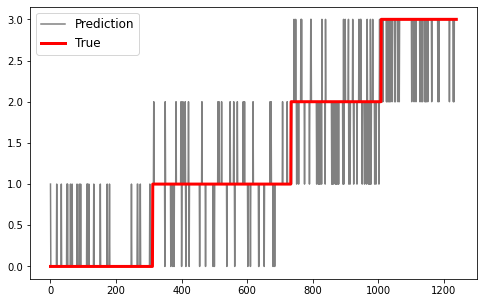

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


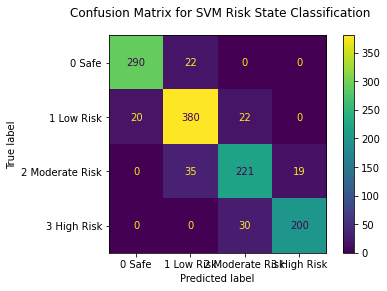

                 precision    recall  f1-score   support

         0 Safe       0.94      0.93      0.93       312
     1 Low Risk       0.87      0.90      0.88       422
2 Moderate Risk       0.81      0.80      0.81       275
    3 High Risk       0.91      0.87      0.89       230

       accuracy                           0.88      1239
      macro avg       0.88      0.88      0.88      1239
   weighted avg       0.88      0.88      0.88      1239



TypeError: ignored

In [ ]:
pipe=Pipeline([ 
    ('scale',StandardScaler())
    ,('selectK', SelectKBest(score_func=f_classif, k=20))          #select k best features
    ,('SVC', SVC(C=3,kernel='rbf',gamma=0.05))          #SVM classifier
])

HP_space={
         'selectK__score_func':[f_classif,mutual_info_classif],
         'selectK__k':[30,20,15,25],
         'SVC__C':[0.1,2],
         'SVC__kernel':['poly','rbf'],
         'SVC__gamma':['scale']
         }
search = GridSearchCV(pipe, HP_space, cv=5,scoring=scoring, refit='accuracy')

## ============================== Training ===============================
search.fit(X_train_imputed_1,y_train_imputed_1)


PrintMySearch_Clf(search)

## ============================== Testing ===============================

bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test_imputed_1)

print('Accuracy score is: %.5f'%accuracy_score(y_test_imputed_1,y_predict))

sort_ind=np.argsort(y_test_imputed_1)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test_imputed_1[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()


print(classification_report(y_test_imputed_1,y_predict, target_names=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


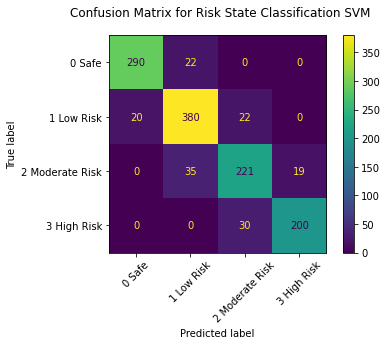

In [ ]:
#PLOT CONFUSION MATRIX

confusion_matrix_RS_1 = plot_confusion_matrix(search, X_test_imputed_1, y_test_imputed_1,display_labels=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"])
confusion_matrix_RS_1.figure_.suptitle("Confusion Matrix for Risk State Classification SVM")
plt.xticks(np.arange(4), ["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"], rotation=45)
#plt.yticks(tick_marks, target_names)

plt.show()

# **# Dataset 2**





[0.         0.         0.         0.13333333 0.         0.
 0.26666667 0.         0.         0.53333333 0.         0.
 0.33333333 0.26666667 0.13333333 0.13333333 0.13333333 0.
 0.         0.        ]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 2. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]


Text(0.5, 1.0, 'Histogram of the Risk State')

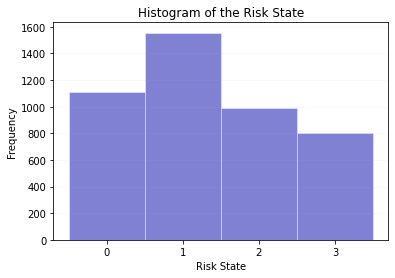

In [ ]:
# First relabel X_2 and y_2

#---- Relabel the y matrix to define the four classes ---- #
#print(y[0:300])
y_risk2 =  np.copy(y_2)
print(y_risk2[40:60])

for i in range(len(y_risk2)):
  if y_risk2[i] < 0.1:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk2[i]= 0; # Safe = 0
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  elif y_risk2[i] > 0.7:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk2[i]= 3; # High Risk = 3
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  elif y_risk2[i] < 0.7 and y_risk2[i] >= 0.35:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk2[i]=2; # Moderate Risk = 2
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])
  else:
    # print('For index ', i, ', the old risk factor is R = ', y_risk[i])
    y_risk2[i]=1; # Low Risk = 1
    # print('For index ', i, ', the new risk factor is R = ', y_risk[i])

#print(y_risk2.astype(int)) # Ensure the labels are integers
print(y_risk2[40:60])

#from sklearn.preprocessing import LabelBinarizer
#y_dense = LabelBinarizer().fit_transform(y_risk)
#print(y_dense[40:60])

# Plot histogram of y risk states
n, bins, patches = plt.hist(x=y_risk2, bins= np.arange(5)-0.5,  color='#0504aa', alpha=0.5,linewidth=0.8, edgecolor='white'
#n, bins, patches = plt.hist(x=y_risk, bins= 'auto',  color='#0504aa', alpha=0.5,linewidth=0.8, edgecolor='white'
                            )
plt.grid(axis='y',alpha=0.1)

plt.xlabel('Risk State')
plt.ylabel('Frequency')
plt.xticks(range(4))
#plt.xticks(np.linspace(0,3,1))
#plt.axis(['Safe', 'Low Risk', 'Moderate Risk', 'High Risk'])
plt.title('Histogram of the Risk State')
#plt.text(23, 45, r'$\mu=15, b=3$')

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Best Param:  {'mlpc': MLPClassifier(hidden_layer_sizes=(10, 2), learning_rate_init=0.05, max_iter=150,
              random_state=1, solver='sgd'), 'mlpc__activation': 'relu', 'mlpc__hidden_layer_sizes': (10, 2), 'mlpc__learning_rate_init': 0.05, 'mlpc__max_iter': 150, 'mlpc__solver': 'sgd'}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('mlpc',
                 MLPClassifier(hidden_layer_sizes=(10, 2),
                               learning_rate_init=0.05, max_iter=150,
                               random_state=1, solver='sgd'))])


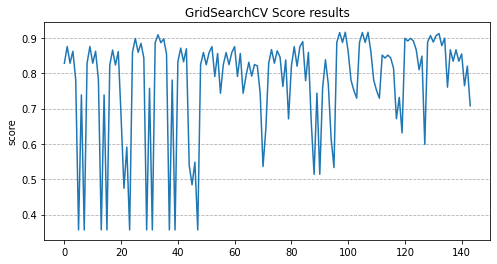

 Accuracy is 0.828352 {'mlpc': MLPClassifier(hidden_layer_sizes=(10, 2), learning_rate_init=0.05, max_iter=150,
              random_state=1, solver='sgd'), 'mlpc__activation': 'logistic', 'mlpc__hidden_layer_sizes': (10, 2), 'mlpc__learning_rate_init': 0.05, 'mlpc__max_iter': 300, 'mlpc__solver': 'adam'}
 Accuracy is 0.875608 {'mlpc': MLPClassifier(hidden_layer_sizes=(10, 2), learning_rate_init=0.05, max_iter=150,
              random_state=1, solver='sgd'), 'mlpc__activation': 'logistic', 'mlpc__hidden_layer_sizes': (10, 2), 'mlpc__learning_rate_init': 0.05, 'mlpc__max_iter': 300, 'mlpc__solver': 'sgd'}
 Accuracy is 0.828352 {'mlpc': MLPClassifier(hidden_layer_sizes=(10, 2), learning_rate_init=0.05, max_iter=150,
              random_state=1, solver='sgd'), 'mlpc__activation': 'logistic', 'mlpc__hidden_layer_sizes': (10, 2), 'mlpc__learning_rate_init': 0.05, 'mlpc__max_iter': 150, 'mlpc__solver': 'adam'}
 Accuracy is 0.862147 {'mlpc': MLPClassifier(hidden_layer_sizes=(10, 2), learnin

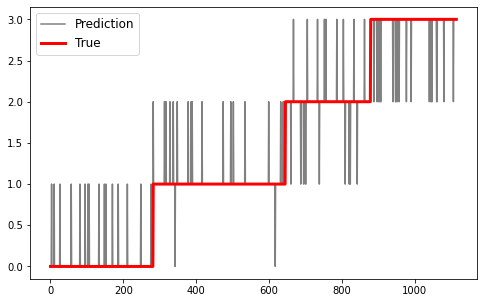

NameError: ignored

In [ ]:
from sklearn.neural_network import MLPClassifier # NOTE IT TAKES A LONG TIME in between 15 and 30 minutes :)

Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_risk2, test_size=Test_ratio, random_state=4720)

mlp_RS_2 = MLPClassifier(solver='adam', max_iter=300,random_state=1
                         ) # adam solver is used for weight optimization as it works better on large datasets
RS_pipeline_2 = Pipeline([
                          ('standardize', StandardScaler()),
                          #('selectK', SelectKBest(score_func=f_classif, k=20)),       # select k best features
                          ('mlpc', mlp_RS_2)
                          ])
#RS_pipeline_2.fit(X_train_imputed_1,y_train_imputed_1)
#RS_pipeline_2.score(X_test_imputed_1,y_test_imputed_1)

HP_space_RS_2={
     'mlpc': [MLPClassifier(random_state=1)],
     'mlpc__solver': ['adam', 'sgd'],
     'mlpc__learning_rate_init': [0.05, 0.001],
     'mlpc__max_iter': [300, 150],
     'mlpc__hidden_layer_sizes': [ (10,2), (10,2), (20,1), (20,2),(20,3), (100,1)], #(5,1), (5,2),
     'mlpc__activation': ['logistic', 'tanh', 'relu'],
     #'selectK__k':[20,25],
     #'mlpc__alpha': [0.0001, 0.001, 0.005],
     #'mlpc__early_stopping': [True, False]
     }

search_RS_2 = GridSearchCV(RS_pipeline_2, HP_space_RS_2, cv=5, scoring=scoring, refit='accuracy')


## ============================== Training ===============================
search_RS_2.fit(X_train21, y_train21)

PrintMySearch_Clf(search_RS_2)

## ============================== Testing ===============================

bestmodel_RS_2=search_RS_2.best_estimator_

y_predict=bestmodel_RS_2.predict(X_test21)

print('Accuracy score is: %.5f'%accuracy_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

#print(classification_report(y_test21,y_predict, target_names=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"]))

                 precision    recall  f1-score   support

         0 Safe       0.99      0.94      0.97       282
     1 Low Risk       0.93      0.95      0.94       363
2 Moderate Risk       0.85      0.92      0.88       234
    3 High Risk       0.96      0.92      0.94       236

       accuracy                           0.93      1115
      macro avg       0.93      0.93      0.93      1115
   weighted avg       0.94      0.93      0.93      1115



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


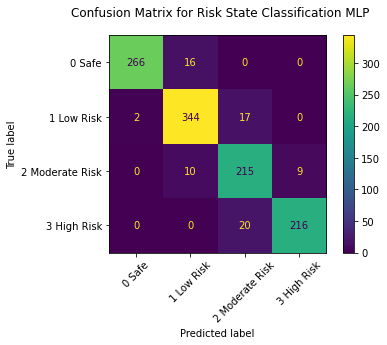

In [ ]:
#PLOT classification report and CONFUSION MATRIX
print(classification_report(y_test21,y_predict, target_names=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"]))

confusion_matrix_RS_1 = plot_confusion_matrix(search_RS_2, X_test21, y_test21,display_labels=["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"])
confusion_matrix_RS_1.figure_.suptitle("Confusion Matrix for Risk State Classification MLP")
plt.xticks(np.arange(4), ["0 Safe","1 Low Risk","2 Moderate Risk","3 High Risk"], rotation=45)
#plt.yticks(tick_marks, target_names)

plt.show()

**Regressor, pipeline 1 (not NN)**

**Step 1: Model selection**

We will test the same regression models as used during practicum 3, in which we got to familiarize ourselves with regression.

Note that we will be using the default settings as much as possible. The functions used, usually have some sort of underlying algorithms in order to determine the hyperparameters. To keep our model comparison a bit more uniform, we will use these values to get an impression about the adequacy of each model.

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('SVR', SVR())])


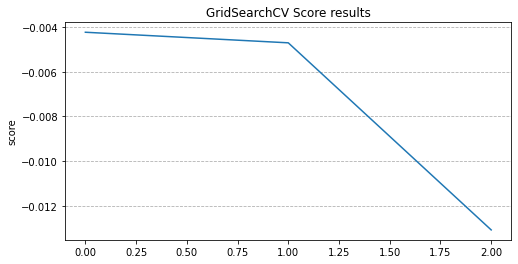

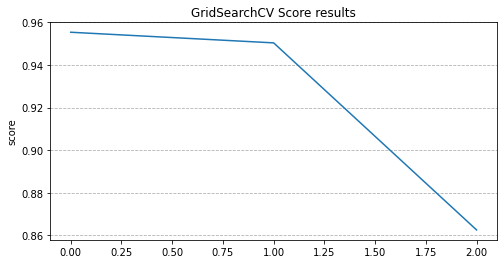

-MSE score:  -0.004240 {'selectK__k': 30}
-MSE score:  -0.004712 {'selectK__k': 20}
-MSE score:  -0.013065 {'selectK__k': 10}
R2 score:  0.955386 {'selectK__k': 30}
R2 score:  0.950395 {'selectK__k': 20}
R2 score:  0.862493 {'selectK__k': 10}
MSE score is: 0.00437
R2 score is: 0.95867


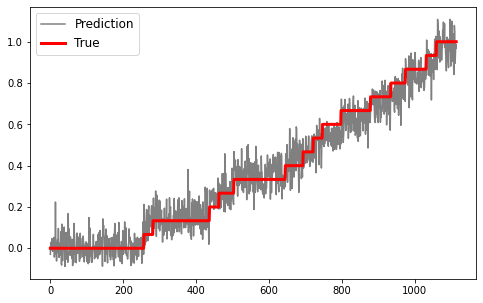

In [ ]:
#######################################################################################################################
# Pipeline 1.a Model selection, SVM
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR())                                                 #SVM regressor
])

HP_space = {
    'selectK__k':[30,20,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('LinR', LinearRegression())])


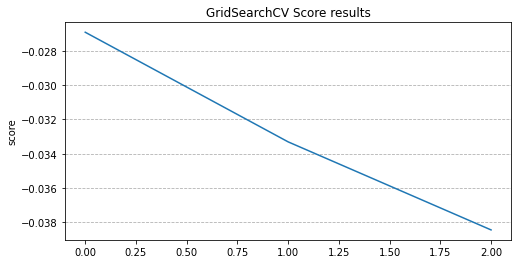

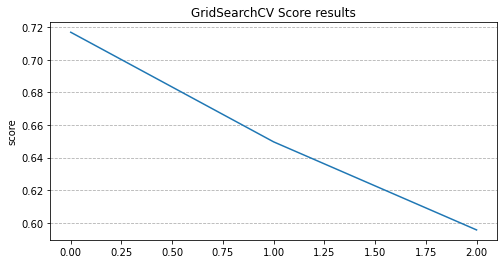

-MSE score:  -0.026915 {'selectK__k': 30}
-MSE score:  -0.033306 {'selectK__k': 20}
-MSE score:  -0.038439 {'selectK__k': 10}
R2 score:  0.716805 {'selectK__k': 30}
R2 score:  0.649634 {'selectK__k': 20}
R2 score:  0.595685 {'selectK__k': 10}
MSE score is: 0.02779
R2 score is: 0.73714


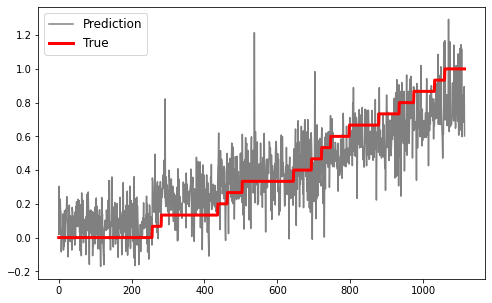

In [ ]:
#######################################################################################################################
# Pipeline 1.b Model selection, LinearRegression
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('LinR', LinearRegression())                                   # linear regressor
])

HP_space = {
    'selectK__k':[30,20,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('RidgeR', Ridge())])


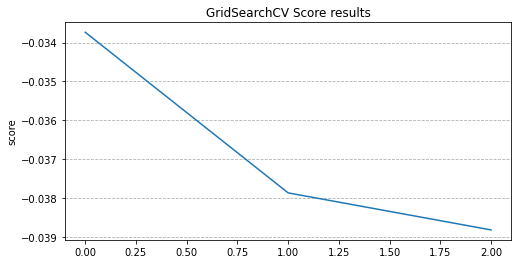

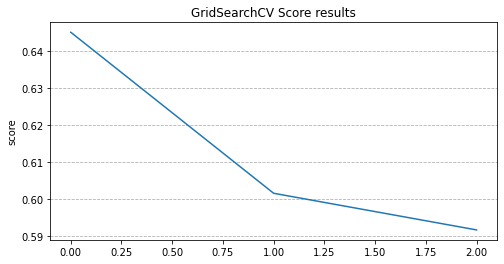

-MSE score:  -0.033732 {'selectK__k': 30}
-MSE score:  -0.037870 {'selectK__k': 20}
-MSE score:  -0.038825 {'selectK__k': 10}
R2 score:  0.645161 {'selectK__k': 30}
R2 score:  0.601566 {'selectK__k': 20}
R2 score:  0.591645 {'selectK__k': 10}
MSE score is: 0.03599
R2 score is: 0.65955


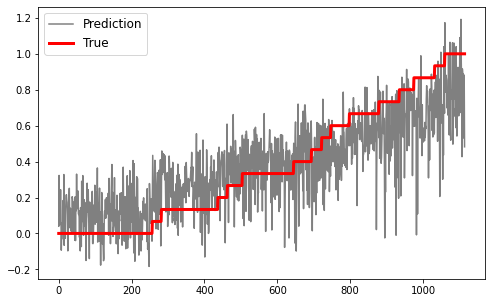

In [ ]:
#######################################################################################################################
# Pipeline 1.c Model selection, Ridge
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('RidgeR', Ridge(alpha=1.0))                                   # Ridge regressor
])

HP_space = {
    'selectK__k':[30,20,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Best Param:  {'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('LassoR', Lasso())])


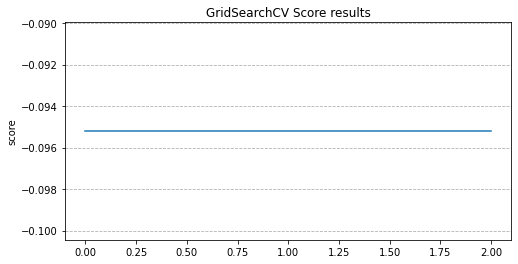

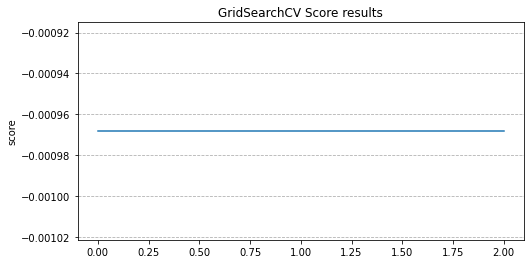

-MSE score:  -0.095204 {'selectK__k': 30}
-MSE score:  -0.095204 {'selectK__k': 20}
-MSE score:  -0.095204 {'selectK__k': 10}
R2 score:  -0.000968 {'selectK__k': 30}
R2 score:  -0.000968 {'selectK__k': 20}
R2 score:  -0.000968 {'selectK__k': 10}
MSE score is: 0.10619
R2 score is: -0.00456


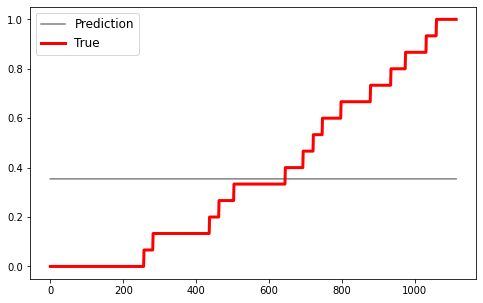

In [ ]:
#######################################################################################################################
# Pipeline 1.d Model selection, Lasso
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('LassoR', Lasso(alpha=1.0))                                   # Lasso regressor
])

HP_space = {
    'selectK__k':[30,20,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

The best model appears to be the SVR. We will be mocing forward using this model.

**Step 2: hyperparameter ballparks**

The next step is to get a general idea about the hyperparameters. We are not trying to get finalized values yet for all of them. Instead, we are mainly curious about their general order of magnitude (or in some cases the type used, such as the kernel).

Just to repeat, we will be using the SVR model.

Best Param:  {'SVR__gamma': 'auto', 'SVR__kernel': 'rbf', 'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('SVR', SVR(gamma='auto'))])


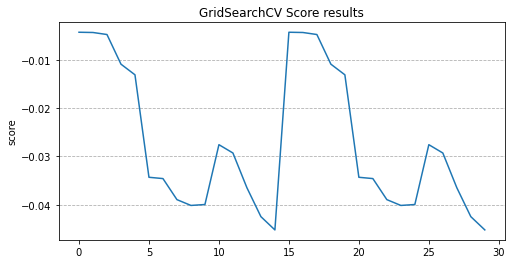

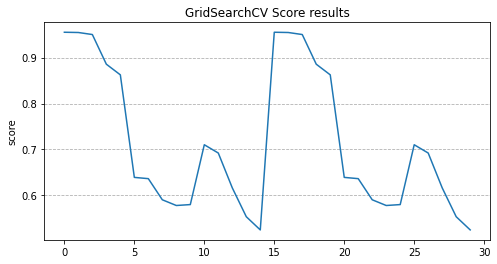

-MSE score:  -0.004240 {'SVR__gamma': 'scale', 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004291 {'SVR__gamma': 'scale', 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004712 {'SVR__gamma': 'scale', 'SVR__kernel': 'rbf', 'selectK__k': 20}
-MSE score:  -0.010859 {'SVR__gamma': 'scale', 'SVR__kernel': 'rbf', 'selectK__k': 15}
-MSE score:  -0.013065 {'SVR__gamma': 'scale', 'SVR__kernel': 'rbf', 'selectK__k': 10}
-MSE score:  -0.034313 {'SVR__gamma': 'scale', 'SVR__kernel': 'linear', 'selectK__k': 30}
-MSE score:  -0.034583 {'SVR__gamma': 'scale', 'SVR__kernel': 'linear', 'selectK__k': 25}
-MSE score:  -0.038949 {'SVR__gamma': 'scale', 'SVR__kernel': 'linear', 'selectK__k': 20}
-MSE score:  -0.040152 {'SVR__gamma': 'scale', 'SVR__kernel': 'linear', 'selectK__k': 15}
-MSE score:  -0.039961 {'SVR__gamma': 'scale', 'SVR__kernel': 'linear', 'selectK__k': 10}
-MSE score:  -0.027554 {'SVR__gamma': 'scale', 'SVR__kernel': 'poly', 'selectK__k': 30}
-MSE score:  -0.029280 {'SV

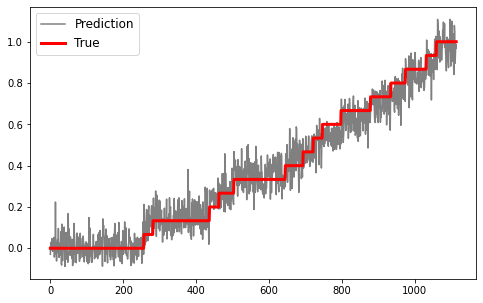

In [ ]:
#######################################################################################################################
# Pipeline 2.a Hyperparameter ballparks
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale'))                       #SVM regressor
])

HP_space = {
    'selectK__k':[30,25,20,15,10], 
    'SVR__kernel':['rbf','linear','poly'],
    'SVR__gamma':['scale','auto']
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Notes:

For k in kbest: based on k alone 30 or 25 is not very different. Values below 20 result is a significant drop in score.

For kernel: the 'sigmoid option is by far the worst (is left out for proper comparison, as the y axis became useless). 'rbf' appears to be the best choice.

For gamma: scale is better for both rbf and poly. Not as much difference for linear.

When C was added to the hyperparameters the run time started to increase significantly --> start new pipeline

Best Param:  {'SVR__C': 5, 'SVR__kernel': 'rbf', 'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('SVR', SVR(C=5))])


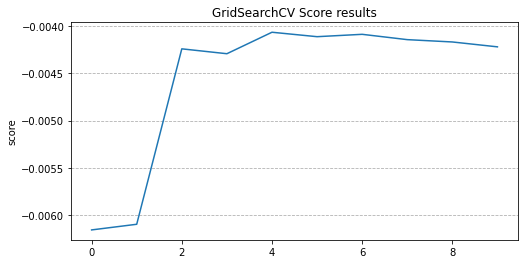

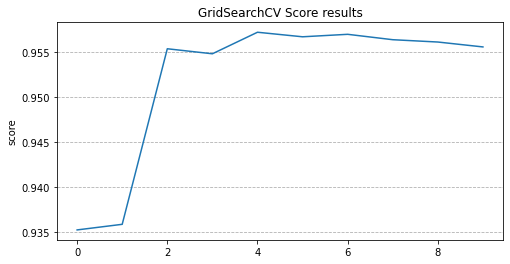

-MSE score:  -0.006157 {'SVR__C': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.006097 {'SVR__C': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004240 {'SVR__C': 1, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004291 {'SVR__C': 1, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004064 {'SVR__C': 5, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004111 {'SVR__C': 5, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004086 {'SVR__C': 10, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004142 {'SVR__C': 10, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004167 {'SVR__C': 100, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004219 {'SVR__C': 100, 'SVR__kernel': 'rbf', 'selectK__k': 25}
R2 score:  0.935210 {'SVR__C': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 30}
R2 score:  0.935835 {'SVR__C': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 25}
R2 score:  0.955386 {'SVR__C': 1, 'SVR__kernel': 'rbf', 'selectK__k'

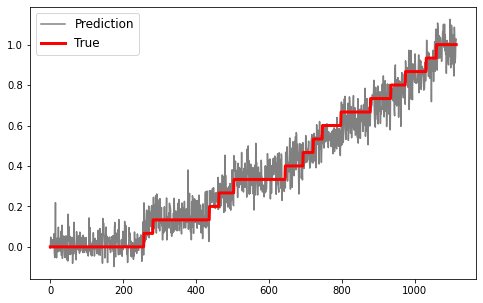

In [ ]:
#######################################################################################################################
# Pipeline 2.b Hyperparameter ballparks
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=0.1))                 #SVM regressor
])

HP_space = {
    'selectK__k':[30,25], 
    'SVR__kernel':['rbf'],
    'SVR__C':[0.1,1,5,10,100]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Notes:

For C: 0.1 results in the worst scores, followed by 100. The other values of C are all very close to each other. 5 results in the best scores.

Epsilon also adds a lot of run-time --> new pipeline

Best Param:  {'SVR__C': 5, 'SVR__epsilon': 0.01, 'SVR__kernel': 'rbf', 'selectK__k': 25}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=25,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('SVR', SVR(C=5, epsilon=0.01))])


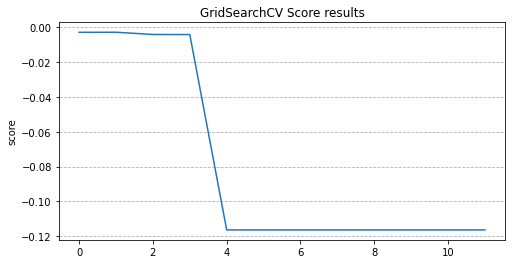

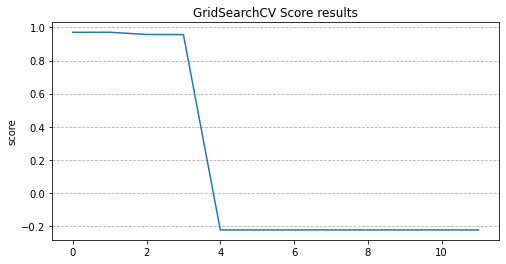

-MSE score:  -0.002821 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.002782 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.004064 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.004111 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 0.5, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 0.5, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 1, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 1, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 5, 'SVR__kernel': 'rbf', 'selectK__k': 30}
-MSE score:  -0.116362 {'SVR__C': 5, 'SVR__epsilon': 5, 'SVR__kernel': 'rbf', 'selectK__k': 25}
-MSE score:  -0.116362 {'S

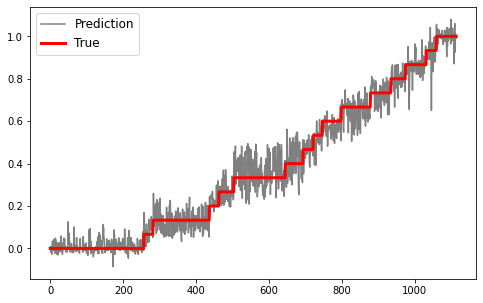

In [ ]:
#######################################################################################################################
# Pipeline 2.c Hyperparameter ballparks
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=0.1,epsilon=0.01))   #SVM regressor
])

HP_space = {
    'selectK__k':[30,25], 
    'SVR__kernel':['rbf',],
    'SVR__C':[5],
    'SVR__epsilon':[0.01,0.1,0.5,1,5,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Notes:

For epsilon: the lower values result in adequate solution, but above 0.1 the score decreases significantly --> basicly unusable --> lower value for epsilon = better

Best Param:  {'SVR__C': 5, 'SVR__epsilon': 0.01, 'selectK__k': 25}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=25,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('SVR', SVR(C=5, epsilon=0.01))])


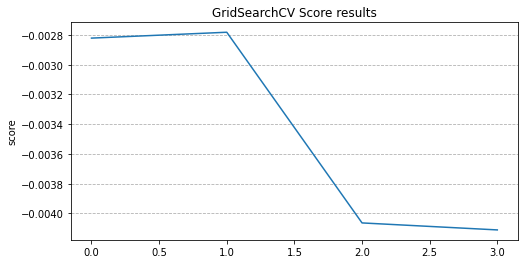

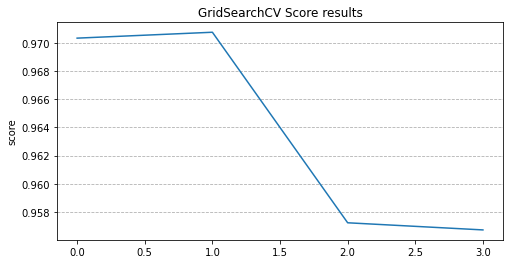

-MSE score:  -0.002821 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'selectK__k': 30}
-MSE score:  -0.002782 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'selectK__k': 25}
-MSE score:  -0.004064 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'selectK__k': 30}
-MSE score:  -0.004111 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'selectK__k': 25}
R2 score:  0.970330 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'selectK__k': 30}
R2 score:  0.970749 {'SVR__C': 5, 'SVR__epsilon': 0.01, 'selectK__k': 25}
R2 score:  0.957226 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'selectK__k': 30}
R2 score:  0.956720 {'SVR__C': 5, 'SVR__epsilon': 0.1, 'selectK__k': 25}
MSE score is: 0.00278
R2 score is: 0.97366


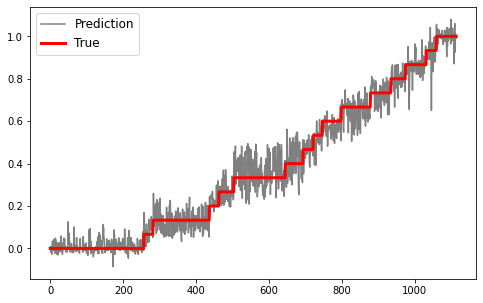

In [ ]:
#######################################################################################################################
# Pipeline 2.d Hyperparameter ballparks (best)
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=10,epsilon=0.01))     #SVM regressor
])

HP_space = {
    'selectK__k':[30,25], 
    'SVR__C':[5],
    'SVR__epsilon':[0.01,0.1]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

End of hyperparameter ballpark analysis.

**Step 3: hyperparameter fine-tuning**

In the previous bit we have established the following parameters as set:

SelectKBest: k = 30 - 25

SVR: kernel = 'rbf', gamma = 'scale' 

SVR: C = 1 - 10, epsilon = 0.01 - 0.1

In [ ]:
# WARNING: this will take a long, long, long, long, long, long, long, long, long, time
#######################################################################################################################
# Pipeline 3.a Hyperparameter fine-tuning
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=30)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=10,epsilon=0.01))     #SVM regressor
])

HP_space = {
    'selectK__k':[30,29,28,27,26,25], 
    'SVR__C':[1,2,3,4,5,6,7,8,9,10],
    'SVR__epsilon':[0.01,0.025,0.05,0.075,0.1]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Interestingly enough, k =25 results in the best prediction, so maybe we can go lower.

In [ ]:
# WARNING: this will take a long, long, long, long, long, long, long, long, long, time
#######################################################################################################################
# Pipeline 3.b Hyperparameter fine-tuning
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=10,epsilon=0.01))     #SVM regressor
])

HP_space = {
    'selectK__k':[25,24,23,22,21,20], 
    'SVR__C':[1,2,3,4,5,6,7,8,9,10],
    'SVR__epsilon':[0.01,0.025,0.05,0.075,0.1]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

**Final Model**

Using the gridsearches above, we can end with the best model for the tested hyperparameters:

In [ ]:
#######################################################################################################################
# Pipeline 4 Final model
#######################################################################################################################
Test_ratio = 0.25
X_train21, X_test21, y_train21, y_test21 = train_test_split(X_2, y_2, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=25)),       #select k best features
                 ('SVR', SVR(kernel='rbf',gamma='scale',C=4,epsilon=0.025))     #SVM regressor
])

HP_space = {
    'selectK__k':[25], 
    'SVR__C':[4],
    'SVR__epsilon':[0.025]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

**Regression model 2: neural network**

In [ ]:
#######################################################################################################################
# Pipeline 1.a Ballparks: depth and width
#######################################################################################################################
Test_ratio = 0.25
X_train22, X_test22, y_train22, y_test22 = train_test_split(imputed_data, y, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('MLPR', MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))     # NN regressor
])

HP_space = {
    'selectK__k':[30,25,20],
    'MLPR__hidden_layer_sizes':[(100,100),(22,22,22),(10,10,10,10),(5,5,5,5,5,4)]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

In all situations the (100,100) NN obtains better results

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Best Param:  {'MLPR__alpha': 0.01, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__solver': 'adam', 'selectK__k': 25}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=25,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('MLPR',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 100)))])


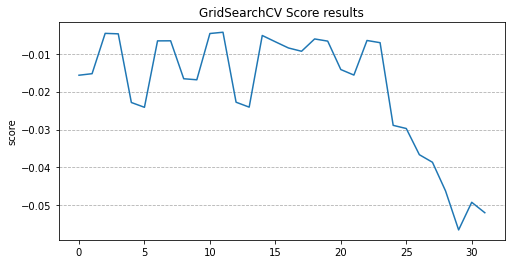

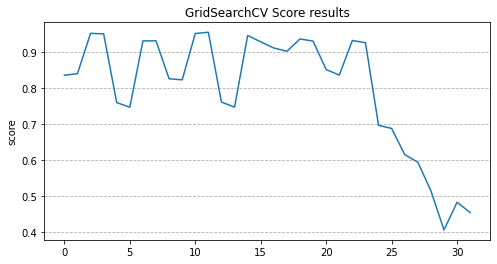

-MSE score:  -0.015684 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__solver': 'sgd', 'selectK__k': 30}
-MSE score:  -0.015278 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__solver': 'sgd', 'selectK__k': 25}
-MSE score:  -0.004646 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004769 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.022877 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (22, 22, 22), 'MLPR__solver': 'sgd', 'selectK__k': 30}
-MSE score:  -0.024144 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (22, 22, 22), 'MLPR__solver': 'sgd', 'selectK__k': 25}
-MSE score:  -0.006627 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (22, 22, 22), 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.006608 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (22, 22, 22), 'MLPR_

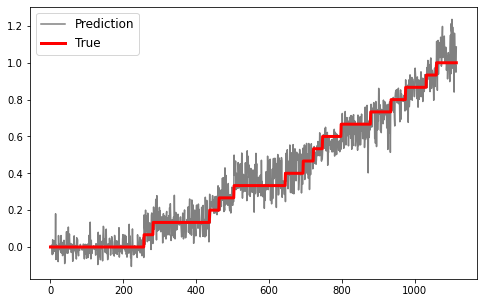

In [ ]:
#######################################################################################################################
# Pipeline 1.b Ballparks: remaining parameters
#######################################################################################################################
Test_ratio = 0.25
X_train22, X_test22, y_train22, y_test22 = train_test_split(imputed_data, y, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('MLPR', MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))     # NN regressor
])

HP_space = {
    'selectK__k':[30,25],
    'MLPR__hidden_layer_sizes':[(100,100),(22,22,22)],
    'MLPR__solver':['sgd','adam'],
    'MLPR__alpha':[0.0001,0.01,1,10]
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

As expected, Adam performs better for all situations.
Alpha seems to have no concrete effect on the final value of MSE or R2, thus the default option will be used

Best Param:  {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'adaptive', 'MLPR__solver': 'adam', 'selectK__k': 25}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=25,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('MLPR',
                 MLPRegressor(hidden_layer_sizes=(100, 100),
                              learning_rate='adaptive'))])


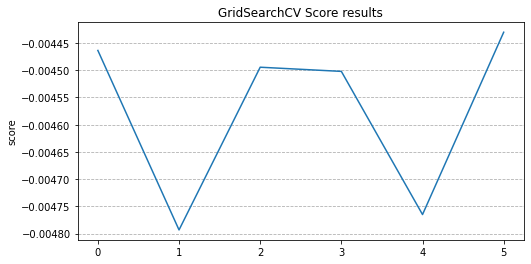

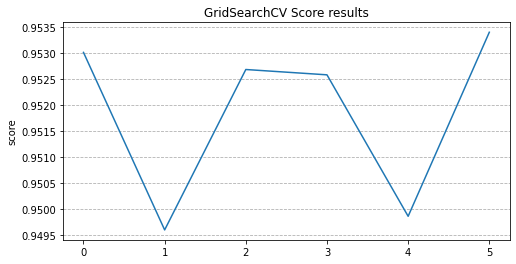

-MSE score:  -0.004464 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004793 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.004495 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'invscaling', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004502 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'invscaling', 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.004765 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'adaptive', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004430 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'adaptive', 'MLPR__solver': 'adam', 'selectK__k': 25}
R2 score:  0

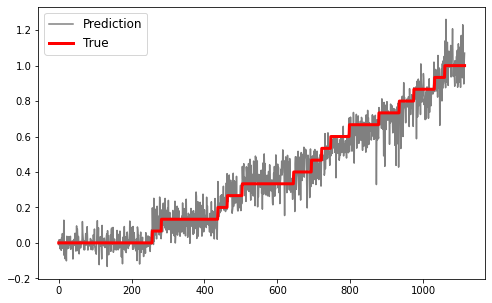

In [ ]:
#######################################################################################################################
# Pipeline 1.c Ballparks: remaining parameters
#######################################################################################################################
Test_ratio = 0.25
X_train22, X_test22, y_train22, y_test22 = train_test_split(imputed_data, y, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('MLPR', MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))     # NN regressor
])

HP_space = {
    'selectK__k':[30,25],
    'MLPR__hidden_layer_sizes':[(100,100)],
    'MLPR__solver':['adam'],
    'MLPR__alpha':[0.0001],
    'MLPR__learning_rate': ['constant','invscaling','adaptive']
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

The difference between the different learning rate can be considered rather minimal.

Interestingly enough the results which of these performs better varies per run. none of them winning out. Thus no conclusive statement can be made about which is better. As such, the default option will be used.

Best Param:  {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('MLPR', MLPRegressor(hidden_layer_sizes=(110, 110)))])


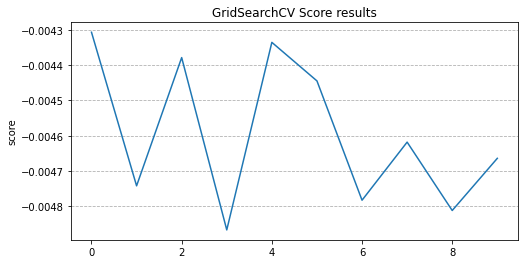

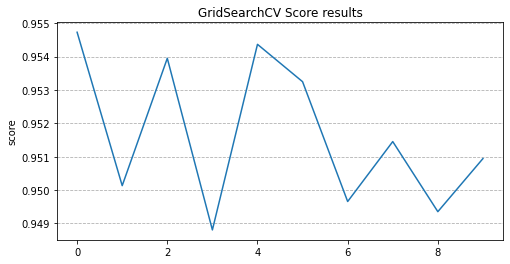

-MSE score:  -0.004307 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004742 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.004379 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004867 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.004336 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004445 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (100, 100), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
-MSE score:  -0.

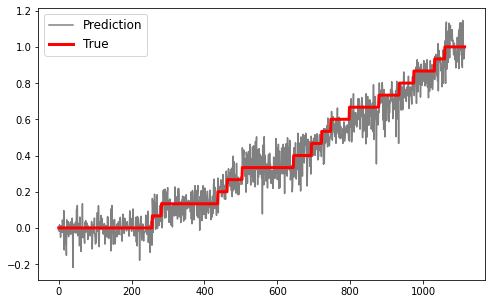

In [ ]:
#######################################################################################################################
# Pipeline 2.a fine-tuning: width
#######################################################################################################################
Test_ratio = 0.25
X_train22, X_test22, y_train22, y_test22 = train_test_split(imputed_data, y, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('MLPR', MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))     # NN regressor
])

HP_space = {
    'selectK__k':[30,25],
    'MLPR__hidden_layer_sizes':[(110,110),(110,100),(100,100),(100,90),(90,90)],
    'MLPR__solver':['adam'],
    'MLPR__alpha':[0.0001],
    'MLPR__learning_rate': ['constant']
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

Best Param:  {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
Best Estimator Pipeline(steps=[('standardize', StandardScaler()),
                ('selectK',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f888ca645f0>)),
                ('MLPR', MLPRegressor(hidden_layer_sizes=(110, 110)))])


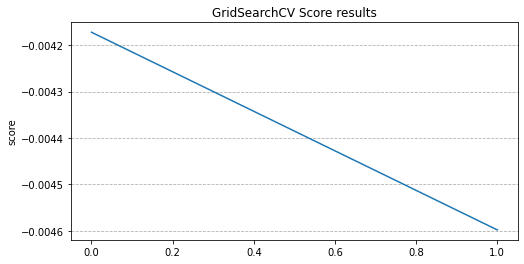

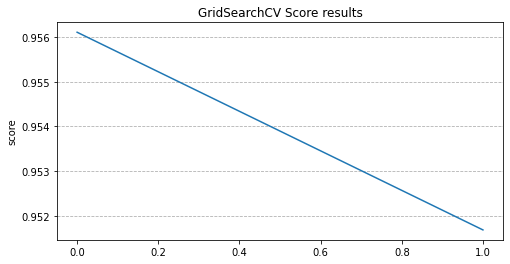

-MSE score:  -0.004172 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
-MSE score:  -0.004598 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
R2 score:  0.956109 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 30}
R2 score:  0.951681 {'MLPR__alpha': 0.0001, 'MLPR__hidden_layer_sizes': (110, 110), 'MLPR__learning_rate': 'constant', 'MLPR__solver': 'adam', 'selectK__k': 25}
MSE score is: 0.00436
R2 score is: 0.95875


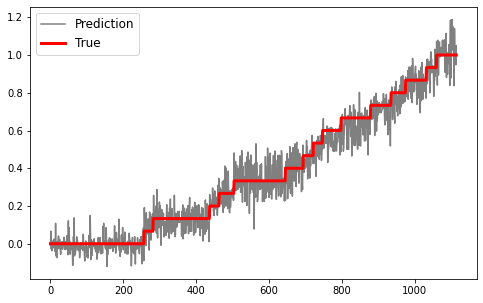

In [ ]:
#######################################################################################################################
# Pipeline 3 final NN model
#######################################################################################################################
Test_ratio = 0.25
X_train22, X_test22, y_train22, y_test22 = train_test_split(imputed_data, y, test_size=Test_ratio, random_state=4720)

scoring = {'MSE':'neg_mean_squared_error','r2':make_scorer(r2_score)}

pipe = Pipeline([
                 ('standardize', StandardScaler()),                             # standardize the data
                 ('selectK', SelectKBest(score_func=f_regression, k=20)),       # select k best features
                 ('MLPR', MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))     # NN regressor
])

HP_space = {
    'selectK__k':[30],
    'MLPR__hidden_layer_sizes':[(110,110)],
    'MLPR__solver':['adam'],
    'MLPR__alpha':[0.0001],
    'MLPR__learning_rate': ['constant']
}

search = GridSearchCV(pipe, HP_space, cv=5, scoring=scoring, refit="r2")
#######################################################################################################################
# Training
#######################################################################################################################
search.fit(X_train21,y_train21)

PrintMySearch_Reg(search)

#######################################################################################################################
# Testing
#######################################################################################################################
bestmodel=search.best_estimator_

y_predict=bestmodel.predict(X_test21)

print('MSE score is: %.5f'%mean_squared_error(y_test21,y_predict))
print('R2 score is: %.5f'%r2_score(y_test21,y_predict))

sort_ind=np.argsort(y_test21)
plt.figure(figsize=(8,5))
plt.plot(y_predict[sort_ind],linewidth=1.5,c='gray')
plt.plot(y_test21[sort_ind],linewidth=3,c='red')
plt.legend(['Prediction','True'],loc='best',fontsize=12)
plt.show()

In [ ]:
# set the warnings back on
np.seterr(divide='warn', invalid='warn')